In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import zipfile
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.metrics import roc_curve, auc, confusion_matrix
from imblearn.metrics import sensitivity_score, specificity_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet, MobileNetV2, VGG16, EfficientNetB0, InceptionV3, \
                                           VGG19, Xception, DenseNet121, DenseNet201, ResNet152V2, EfficientNetB5
from tensorflow.keras.layers import Input, AveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

from imblearn.over_sampling import RandomOverSampler 

import os
import glob
import zipfile
import random

# to get consistent results after multiple runs
#tf.random.set_seed(7)
#np.random.seed(7)
#random.seed(7)


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [3]:
def download_zip(url, unzip=True, remove_after_unzip=False):
  
  url = url
  filenames = url.split('/')[-1]
  filedata = get_file(origin=url, fname=os.path.join(os.getcwd(), filenames))

  if unzip:
    local_zip = filenames
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall(f'{os.getcwd()}/')
    zip_ref.close()
  
  if remove_after_unzip:
    os.remove(filenames)  

download_zip("https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip", remove_after_unzip=True)
download_zip("https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip", remove_after_unzip=True)
download_zip("https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip", remove_after_unzip=True)

5528641536/5528640507 [==============================] - 275s 0us/step


In [2]:
a = len(os.listdir('/content/train/melanoma'))
b = len(os.listdir('/content/train/nevus'))
c = len(os.listdir('/content/train/seborrheic_keratosis'))
d = len(os.listdir('/content/valid/melanoma'))
e = len(os.listdir('/content/valid/nevus'))
f = len(os.listdir('/content/valid/seborrheic_keratosis'))
g = len(os.listdir('/content/test/melanoma'))
h = len(os.listdir('/content/test/nevus'))
i = len(os.listdir('/content/test/seborrheic_keratosis'))

print("Total: ",a+b+c+d+e+f+g+h+i)
print("Melanoma: ",a+d+g)
print("Nevus: ",b+e+h)
print("seborrheic_keratosis: ",c+f+i)

Total:  2750
Melanoma:  521
Nevus:  1843
seborrheic_keratosis:  386


In [2]:
def generate_csv(folder, label2int):
    labels = list(label2int)
    df = pd.DataFrame(columns=["filepath", "label"])
    i = 0
    for label in labels:
      folders = f"{folder}/{label}/"
      for filepath in os.listdir(folders):
          df.loc[i] = [os.path.join(folders, filepath), label2int[label]]
          i += 1
    output_file = f"{folder}.csv"
    df.to_csv(output_file)

generate_csv("train", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("valid", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("test", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})

In [3]:
df_null = pd.read_csv('train.csv')
df_null

,Unnamed: 0,filepath,label
0,0,train/nevus/ISIC_0012333.jpg,0
1,1,train/nevus/ISIC_0000073.jpg,0
2,2,train/nevus/ISIC_0014707.jpg,0
3,3,train/nevus/ISIC_0000425.jpg,0
4,4,train/nevus/ISIC_0000133.jpg,0
...,...,...,...
1995,1995,train/melanoma/ISIC_0001102.jpg,1
1996,1996,train/melanoma/ISIC_0011349.jpg,1
1997,1997,train/melanoma/ISIC_0013671.jpg,1
1998,1998,train/melanoma/ISIC_0000162.jpg,1


In [3]:
def generate_samples(csv_file):
  df = pd.read_csv(csv_file)
  samples = len(df)
  print("Number of samples: ", samples)
  return tf.data.Dataset.from_tensor_slices((df["filepath"], df["label"])), samples

train_ds, n_training_samples = generate_samples('train.csv')
valid_ds, n_validation_samples = generate_samples('valid.csv')

Number of samples:  2000
Number of samples:  150


In [5]:
train_ds

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [4]:
def process_path(filepath, label):
  img = tf.io.read_file(filepath)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [224, 224])
  return img, label

valid_ds = valid_ds.map(process_path)
train_ds = train_ds.map(process_path)

for image, label in train_ds.take(1):
    print("Image shape:", image.shape)
    print("Label:", label.numpy())

Image shape: (224, 224, 3)
Label: 0


In [5]:
BATCH_SIZE = 64

def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000): #
  
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  ds = ds.repeat()
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  
  return ds

valid_ds = prepare_for_training(valid_ds, batch_size=BATCH_SIZE, cache="valid-cached-data")
train_ds = prepare_for_training(train_ds, batch_size=BATCH_SIZE, cache="train-cached-data")

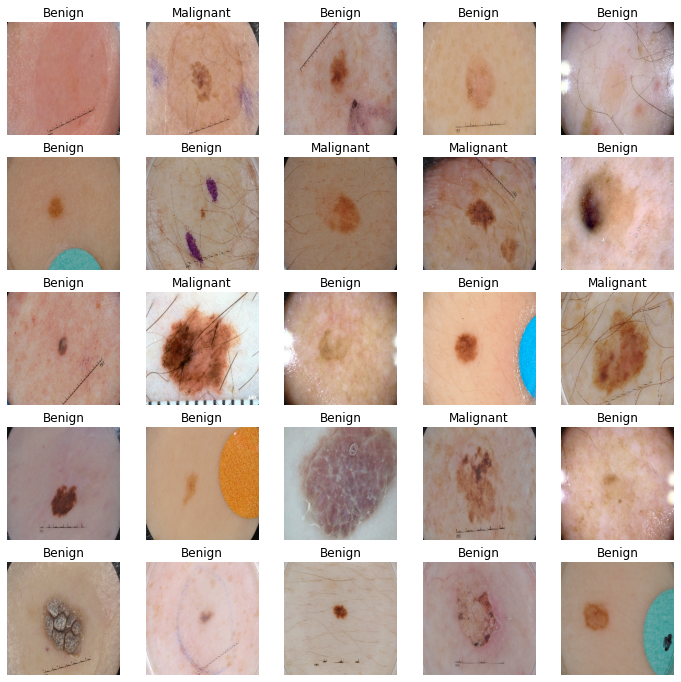

In [10]:
class_names = ["benign", "malignant"]

batch = next(iter(valid_ds))

def show_batch(batch):
  plt.figure(figsize=(12,12))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(batch[0][n])
      plt.title(class_names[batch[1][n].numpy()].title())
      plt.axis('off')
        
show_batch(batch)

In [6]:
image[0].shape

TensorShape([224, 3])

In [9]:
# Models
#module = 'inception_v3' # only works with 299x299 models
module = 'mobilenet_v2' # only works with 224x224 models

module_url = f"https://tfhub.dev/google/tf2-preview/{module}/feature_vector/4"

base_model = hub.KerasLayer(module_url, output_shape=[2048])
base_model.trainable=True

model = tf.keras.Sequential([
    base_model,
    Flatten(), 
    Dense(32, activation='relu'),
    Dropout(0.15), 
    Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=l2(0.01))
])

if module is 'inception_v3':
  model.build([None, 299, 299, 3])

if module is 'mobilenet_v2':
  model.build([None, 224, 224, 3])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                40992     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 2,299,249
Trainable params: 2,265,137
Non-trainable params: 34,112
_______________________________________

In [10]:
#model_name = f"benign-vs-malignant_{batch_size}_{optimizer}"
#tensorboard = tf.keras.callbacks.TensorBoard(log_dir=os.path.join("logs", model_name))
#modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(model_name + "_{val_loss:.3f}.h5", save_best_only=True, verbose=1)
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

In [11]:
history = model.fit(train_ds, validation_data=valid_ds, 
                steps_per_epoch=n_training_samples // BATCH_SIZE, 
                validation_steps=n_validation_samples // BATCH_SIZE, verbose=1, epochs=10)

Epoch 1/10
31/31 [==============================] - 444s 8s/step - loss: 0.3937 - accuracy: 0.9167 - val_loss: 2.4342 - val_accuracy: 0.7891
Epoch 2/10
31/31 [==============================] - 24s 782ms/step - loss: 0.4836 - accuracy: 0.9038 - val_loss: 1.1547 - val_accuracy: 0.8125
Epoch 3/10
31/31 [==============================] - 23s 750ms/step - loss: 0.4762 - accuracy: 0.9084 - val_loss: 1.4557 - val_accuracy: 0.8047
Epoch 4/10
31/31 [==============================] - 24s 762ms/step - loss: 0.4996 - accuracy: 0.8988 - val_loss: 0.8622 - val_accuracy: 0.7891
Epoch 5/10
31/31 [==============================] - 23s 748ms/step - loss: 0.4410 - accuracy: 0.8916 - val_loss: 0.7693 - val_accuracy: 0.7969
Epoch 6/10
31/31 [==============================] - 23s 746ms/step - loss: 0.4723 - accuracy: 0.8741 - val_loss: 0.7411 - val_accuracy: 0.7734
Epoch 7/10
31/31 [==============================] - 23s 747ms/step - loss: 0.4651 - accuracy: 0.8659 - val_loss: 0.9001 - val_accuracy: 0.8047
E

In [ ]:
# evaluation
# load testing set
test_metadata_filename = "test.csv"
df_test = pd.read_csv(test_metadata_filename)
n_testing_samples = len(df_test)
print("Number of testing samples:", n_testing_samples)
test_ds = tf.data.Dataset.from_tensor_slices((df_test["filepath"], df_test["label"]))

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  return ds

test_ds = test_ds.map(process_path)
test_ds = prepare_for_testing(test_ds, cache="test-cached-data")

Number of testing samples: 600


In [ ]:
# convert testing set ke numpy array
y_test = np.zeros((n_testing_samples,))
X_test = np.zeros((n_testing_samples, 299, 299, 3))
for i, (img, label) in enumerate(test_ds.take(n_testing_samples)):
  X_test[i] = img
  y_test[i] = label.numpy()

print("y_test.shape:", y_test.shape)

y_test.shape: (600,)


In [ ]:
m.load_weights("benign-vs-malignant_64_rmsprop_0.381.h5")

In [ ]:
print("Evaluating the model...")
loss, accuracy = m.evaluate(X_test, y_test, verbose=0)
print("Loss:", loss, "  Accuracy:", accuracy)

Evaluating the model...
Loss: 0.45552149415016174   Accuracy: 0.7983333468437195


In [ ]:
def get_predictions(threshold=None):
  y_pred = m.predict(X_test)
  if not threshold:
    threshold = 0.5
  result = np.zeros((n_testing_samples,))
  for i in range(n_testing_samples):
    # test probabilitas melanoma
    if y_pred[i][0] >= threshold:
      result[i] = 1
    # else, dia akan 0 (benign)
  return result

threshold = 0.23
y_pred = get_predictions(threshold)

[[0.59834369 0.40165631]
 [0.27350427 0.72649573]]


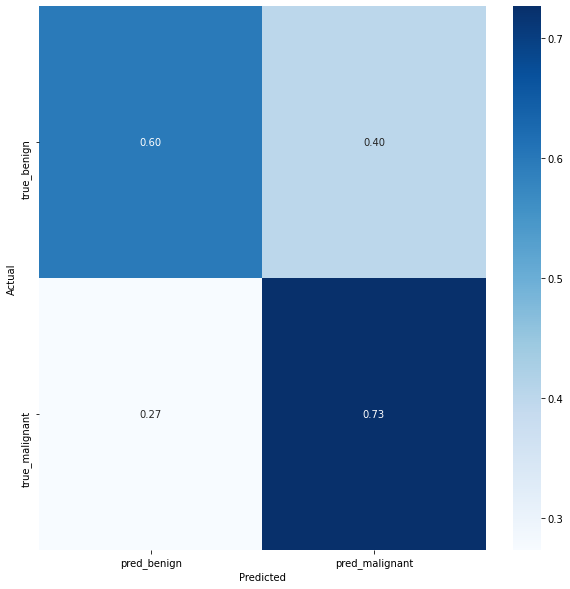

In [ ]:
def plot_confusion_matrix(y_test, y_pred):
  cmn = confusion_matrix(y_test, y_pred)
  cmn = cmn.astype('float') / cmn.sum(axis=1)[:, np.newaxis]
  print(cmn)
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(cmn, annot=True, fmt='.2f', 
              xticklabels=[f"pred_{c}" for c in class_names], 
              yticklabels=[f"true_{c}" for c in class_names],
              cmap="Blues"
              )
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  
  plt.show()

plot_confusion_matrix(y_test, y_pred)

In [ ]:
sensitivity = sensitivity_score(y_test, y_pred)
specificity = specificity_score(y_test, y_pred)

print("Melanoma Sensitivity:", sensitivity)
print("Melanoma Specificity:", specificity)

Melanoma Sensitivity: 0.7264957264957265
Melanoma Specificity: 0.598343685300207


ROC AUC: 0.662


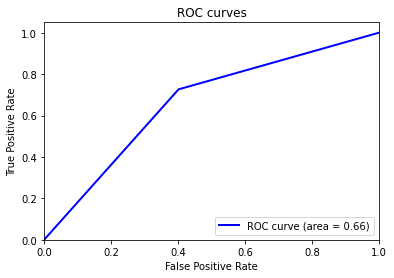

In [ ]:
def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """
    plt.figure()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.3f}")
    plt.plot(fpr, tpr, color="blue", lw=2,
                label='ROC curve (area = {f:.2f})'.format(d=1, f=roc_auc))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc(y_test, y_pred)

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting gambarnya
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = m.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + "\nMalignant")
  else:
    print(fn + "\nBenign")

Saving 1200px-Melanoma.jpg to 1200px-Melanoma (1).jpg
[0.9559688]
1200px-Melanoma.jpg
Malignant
